In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import datetime
from matplotlib import style
style.use('ggplot')
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/Olatomiwa/Documents/SOL PLAATJE UNIVERSITY/HONOURS 2019/RESEARCH/From Supervisor Dr Mosia/first_yahoo_prices_volumes.csv')

In [3]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-09-10,19.680000,19.430000,19.650000,19.610001,4309400.0,18.881136
1,2014-09-11,19.540001,19.200001,19.469999,19.410000,6268000.0,18.688570
2,2014-09-12,19.530001,19.100000,19.530001,19.120001,6563400.0,18.409348
3,2014-09-15,19.209999,18.780001,19.180000,18.860001,7353800.0,18.159008
4,2014-09-16,19.240000,18.750000,18.809999,19.139999,5498400.0,18.428604


+ Checking the change after 7 dqys
+ Lag the data for past 7 days
+ Compare and map the target values
+ 1 = Gain; 0 = Fall;

In [4]:
# takes the 7 day percent changes for the prices in the future
def gain_fall(*args): # *args lets us pass any parameters, any number of arguments which becomes an iterable
    cols = [c for c in args] # passing each column mapping it row wise
    for col in cols:
        if(col > 0):
            return(1)   # GAIN
        if(col < 0):
            return(0)# FALL

In [5]:
df['1day_Lag'] = (df['Adj Close'].shift(-1) - df['Adj Close']) / df['Adj Close']
# .shift shifts up to get the future value old - new divided by 
        
df['1day_target'] = list(map(gain_fall, *[df['1day_Lag']]))

df.dropna(inplace = True)
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,1day_Lag,1day_target
0,2014-09-10,19.680000,19.430000,19.650000,19.610001,4309400.0,18.881136,-0.010199,0.0
1,2014-09-11,19.540001,19.200001,19.469999,19.410000,6268000.0,18.688570,-0.014941,0.0
2,2014-09-12,19.530001,19.100000,19.530001,19.120001,6563400.0,18.409348,-0.013598,0.0
3,2014-09-15,19.209999,18.780001,19.180000,18.860001,7353800.0,18.159008,0.014846,1.0
4,2014-09-16,19.240000,18.750000,18.809999,19.139999,5498400.0,18.428604,0.000523,1.0


In [6]:
df['1day_target'] = df['1day_target'].shift(1)

In [7]:
df['1day_target'].head()

0    NaN
1    0.0
2    0.0
3    0.0
4    1.0
Name: 1day_target, dtype: float64

In [8]:
df['1day_target'].fillna(0, inplace = True)
df['1day_target'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: 1day_target, dtype: float64

In [9]:
# The distribution of the 1day_target mapping
vals = df['1day_target'].values #.tolist optional 
str_vals = [str(i) for i in vals]

print('Data spread: ', Counter(str_vals)) # seeing th way in which buys/sell/hold are distributed

Data spread:  Counter({'1.0': 584, '0.0': 497})


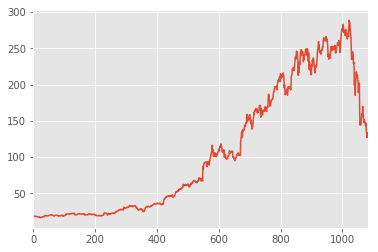

In [10]:
df['Adj Close'].plot()
plt.show()

In [11]:
# return of Adj price (Normalised by one day)
df_return = df['Adj Close'].pct_change()

In [12]:
df_return = df_return.replace([np.inf, -np.inf], np.nan) # replacing infinite changes with nan
df_return.dropna(inplace = True)

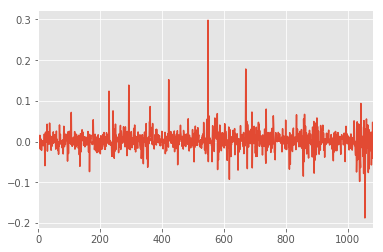

In [13]:
df_return.plot()
plt.show()

days = 7 # Number of days
for i in range(1, days + 1):
    #### Company name and days into the future
    df['{}day_Lag'.format(i)] = (df['Adj Close'].shift(-i) - df['Adj Close']) / df['Adj Close']
    #### .shift shifts up to get the future value old - new divided by 
        
    df['{}day_target'.format(i)] = list(map(gain_fall, *[df['{}day_Lag'.format(i)]for i in range(1, days+1)]))
    
df.fillna(0, inplace = True)
df.head()

In [14]:
data = {'x_features': df['Adj Close'].pct_change(),
                     'y_target': df['1day_target']}
frame = pd.DataFrame(data)

In [15]:
frame.dropna(inplace = True)

In [16]:
frame.head()

,x_features,y_target
1,-0.010199,0.0
2,-0.014941,0.0
3,-0.013598,0.0
4,0.014846,1.0
5,0.000523,1.0


## Neural Net

In [17]:
# Required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import keras.backend as K

Using TensorFlow backend.


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [19]:
# Using train_test_fit to create subsets for fitting and testing
x_train, x_test, y_train, y_test = train_test_split(frame['x_features'], frame['y_target'], test_size = 0.3, random_state = 23, stratify = frame['y_target'])

In [20]:
model = Sequential([
    # Flattening the input Layer into a vector because it is a matrix
    Flatten(),
    
    #First hidden layer 31647 neurons
    Dense(1000, activation = 'relu'), # or tf.nn.relu
    
    #to prevent overfitting
    Dropout(0.20),
    
    Dense(500, activation = 'relu'),
    
    Dropout(0.20),
    
    #output layer with 1 neuron with the sigmoid function to counter for the 2 classes (1 or 0)
    Dense(1, activation = 'softmax') # or tf.nn.softmax
       
])

W1117 22:53:45.107851  1708 deprecation.py:506] From C:\Users\Olatomiwa\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
#Compiler; using the adam optimizer and binary_crossentropy for binary classification
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [22]:
# Fitting the data; 10 iterations
model.fit(x_train.values, y_train.values, epochs = 20)

W1117 22:53:46.556891  1708 deprecation.py:323] From C:\Users\Olatomiwa\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
756/756 [==============================] - 2s 3ms/sample - loss: 7.0379 - acc: 0.5410
Epoch 2/20
756/756 [==============================] - 0s 476us/sample - loss: 7.0379 - acc: 0.5410s - loss: 7.4750 - acc: 
Epoch 3/20
756/756 [==============================] - 0s 484us/sample - loss: 7.0379 - acc: 0.5410
Epoch 4/20
756/756 [==============================] - 0s 457us/sample - loss: 7.0379 - acc: 0.5410
Epoch 5/20
756/756 [==============================] - 0s 459us/sample - loss: 7.0379 - acc: 0.5410
Epoch 6/20
756/756 [==============================] - 0s 459us/sample - loss: 7.0379 - acc: 0.5410
Epoch 7/20
756/756 [==============================] - 0s 434us/sample - loss: 7.0379 - acc: 0.5410
Epoch 8/20
756/756 [==============================] - 0s 436us/sample - loss: 7.0379 - acc: 0.5410
Epoch 9/20
756/756 [==============================] - 0s 444us/sample - loss: 7.0379 - acc: 0.5410
Epoch 10/20
756/756 [==============================] - 0s 445us/sample - loss: 7.0379 -

In [23]:
# Evaluating the test dataset
eval_array = model.evaluate(x_test, y_test)

print("\nTest Data Loss: {}".format(eval_array[0]))
print("\nTest Data Accuracy: {:.5}%".format(eval_array[1] * 100))

324/324 [==============================] - 0s 493us/sample - loss: 7.0514 - acc: 0.5401

Test Data Loss: 7.0513970763595015

Test Data Accuracy: 54.012%


## Reccurrent Neural Net 

In [71]:
model2 = Sequential([
    LSTM(800, activation = 'relu', input_shape = (756, 1), return_sequences = True), # or tf.nn.relu
    Dropout(0.20),
    
    LSTM(450, activation = 'relu'), # or tf.nn.relu
    Dropout(0.20),
    
    Dense(200, activation = 'relu'), # or tf.nn.relu
    Dropout(0.20),
    
    #output layer with 1 neuron with the sigmoid function to counter for the 2 classes (1 or 0)
    Dense(1, activation = 'softmax') # or tf.nn.softmax
       
])

In [74]:
#Compiler; using the adam optimizer and binary_crossentropy for binary classification
model2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

model2.fit(x_train.values, y_train.values, epochs = 20)

eval_array2 = model2.evaluate(x_test, y_test)

print("\nTest Data Loss: {}".format(eval_array2[0]))
print("\nTest Data Accuracy: {:.5}%".format(eval_array2[1] * 100))

## Forecasting into the future
+ Using linear regression as the classifier
+ 30 days into the future

import Quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

df = Quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df['label'])
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

In [75]:
df['PCT_change'] = df['Adj Close'].pct_change()

In [76]:
forecast_col = 'Adj Close'

In [77]:
df.fillna(value=0, inplace=True)

In [78]:
df_new = df[['Adj Close', 'PCT_change', 'Volume']]
df_new.index = df['Date']

In [79]:
df_new.fillna(value=0, inplace=True)
forecast_out = 30 #int(math.ceil(0.01 * len(df_new))) 
df_new['label'] = df_new[forecast_col].shift(-forecast_out)

In [80]:
forecast_out # 30 days 

30

In [81]:
new_x = np.array(df_new.drop(['label'], axis = 1))
new_x = preprocessing.scale(new_x)
new_x = new_x[:-forecast_out]


df_new.dropna(inplace=True)
new_y = np.array(df_new['label'])
X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.2)

In [82]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9497889185349563


In [83]:
newer_x = new_x[: -forecast_out]
x_lately = new_x[-forecast_out: ]

In [84]:
forecast_set = clf.predict(x_lately)

In [85]:
# Next 30 days of unknown Stock Prices
print(forecast_set, accuracy, forecast_out)

[279.44681833 272.68283488 263.98395256 260.22721336 258.88079638
 243.0356932  233.9502548  245.03968903 231.38180959 242.29751983
 237.99136324 236.54856287 227.17903921 227.49591462 219.61712251
 200.84283489 211.74274978 198.40824107 187.0600867  206.5284681
 212.44656967 217.4755733  212.52894719 208.80612665 207.5076961
 212.20903251 204.30998265 203.57963414 189.12490663 200.73006544] 0.9497889185349563 30


## Graphing the forecast

In [86]:
# adding the forecast column
df_new['Forecast'] = np.nan

In [87]:
import time

In [88]:
# Finding out what the last date was, since it was not included in the model
last_date = df_new.iloc[-1].name
last_unix = time.mktime(datetime.datetime.strptime(last_date,"%Y-%m-%d").timetuple()) # last_date.timestamp()
one_day = 86400 # seconds in one day
next_unix = last_unix + one_day

In [89]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df_new.loc[next_date] = [np.nan for _ in range(len(df_new.columns)-1)]+[i] # Iterating throught the forecast set
    #

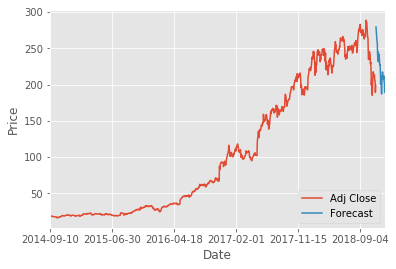

In [90]:
df_new['Adj Close'].plot()
df_new['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()